In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from optimization import *

In [17]:
def dm_reward(xWs, x_hats, phi, b, temp=0.02):
    actions = classify(x=x_hats, phi=phi, b=b, temp=temp)
    return torch.mean(torch.diag(xWs @ actions))

def phi_regularization(phi):
    return torch.norm(torch.norm(phi, dim=1) - 1)

def gr_phi(Xhats, xWs, u, prev_phi=None, prev_b=None, 
           temp=0.02, attempts=5, iters=300): # no additional penalty for finding x?
    if prev_phi is None:
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
    else:
        phi = torch.clone(prev_phi)
        phi.requires_grad_(True)
    if prev_b is None:
        b = torch.zeros(m)
        b.requires_grad_(True)
    else:
        b = torch.clone(prev_b)
        b.requires_grad_(True)
    best_phi = phi.clone()
    best_b = b.clone()
    best_reward = dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, b=b, temp=temp)
    for _ in range(attempts):
        optimizer = torch.optim.Adam([phi], lr=0.0001)
        for _ in tqdm(range(iters), position=0, leave=True):
            optimizer.zero_grad()
            loss = - dm_reward(xWs=xWs, x_hats=Xhats, phi=phi, b=b, temp=temp) # + phi_regularization(phi)
            loss.backward()
            optimizer.step()
            # print(loss)
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_phi = phi.detach()
            best_b = b.detach()
        phi = torch.rand((m, d))
        phi.requires_grad_(True)
        b = torch.zeros(m)
        b.requires_grad_(True)
    return best_phi, best_b

def gr_W(Xs, phi, b, temp=0.02, attempts=5, iters=300):
    m, d = phi.shape
    W = torch.rand((d, m))
    W.requires_grad_(True)
    best_W = W.clone()
    best_reward = dm_reward(xWs=Xs @ W, x_hats=Xs, phi=phi, b=b, temp=temp)
    for _ in range(attempts):
        optimizer = torch.optim.Adam([W], lr=0.0001)
        for _ in range(iters):
            optimizer.zero_grad()
            loss = - dm_reward(xWs=Xs @ W, x_hats=Xs, phi=phi, b=b, temp=temp)
            loss.backward()
            print(loss)
            optimizer.step()
        if loss < -best_reward:
            best_reward = -loss.detach()
            best_W = W.detach()
        W = torch.rand((d, m))
        W.requires_grad_(True)
    return best_W

In [3]:
m = 2
d = 2
n = 1_000
dataset = torch.rand((n, d))
one_m = torch.ones(m)
# W = torch.tensor([[0.8385, 0.5451], [0.7961, 0.9919]])
phi = torch.tensor([[0.5595, 0.0952], [0.1264, 0.7859]])
b = torch.zeros(m)
u = torch.tensor([0.15, 0.1])

In [4]:
# W = gr_W(dataset, phi, b, temp=0.02, attempts=5, iters=500)
phi = torch.tensor([[1., 0.], [1/np.sqrt(5), 2/np.sqrt(5)]], dtype=torch.float32)
W = torch.tensor([[1., 1/np.sqrt(5)], [0., 2/np.sqrt(5)]], dtype=torch.float32)

In [5]:
# x_hat = torch.stack([gragent(x, phi, b, u, attempts=2, iters=200) for x in tqdm(dataset, position=0, leave=True)])

In [6]:
xW = dataset @ W

In [7]:
# -dm_reward(xW, dataset, phi, b, temp=0.02), -dm_reward(dataset @ W, dataset, phi_hat, b_hat, temp=0.02)

In [18]:
phi_hat, b_hat = gr_phi(dataset, xW, u, temp=0.02, attempts=6, iters=2000)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:07<00:00, 283.04it/s]


In [19]:
lbls = [a[0] > a[1] for a in classify(x=dataset, phi=phi, b=b, temp=0.02).T]
preds = [a[0] > a[1] for a in classify(x=dataset, phi=phi_hat, b=b_hat, temp=0.02).T]

In [10]:
# phi_test_1 = [1.0, 0.0]
# phi_test_2 = [0.5, 1.0]
# phi_test_1 /= np.linalg.norm(phi_test_1)
# phi_test_2 /= np.linalg.norm(phi_test_2)

# phi_test = torch.tensor(
#     [phi_test_1, phi_test_2], dtype=torch.float32
# )
# lbls_test = [a[0] > a[1] for a in classify(x=dataset, phi=phi_test, b=b, temp=0.02).T]
# plt.gca().set_aspect('equal')
# plt.scatter(dataset[:,0], dataset[:,1], c=lbls_test)

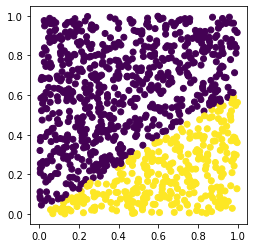

In [11]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=lbls)

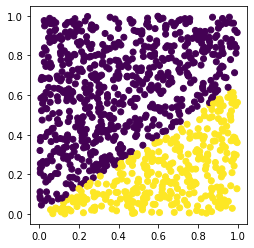

In [20]:
plt.gca().set_aspect('equal')
plt.scatter(dataset[:,0], dataset[:,1], c=preds)

In [21]:
phi, b

(tensor([[1.0000, 0.0000],
         [0.4472, 0.8944]]),
 tensor([0., 0.]))

In [22]:
phi_hat, b_hat

(tensor([[0.9230, 0.3849],
         [0.7322, 0.6811]]),
 tensor([0., 0.]))

In [23]:
W @ phi, W @ phi_hat

(tensor([[1.2000, 0.4000],
         [0.4000, 0.8000]]),
 tensor([[1.2504, 0.6895],
         [0.6549, 0.6092]]))

In [25]:
torch.norm(phi_hat, dim=1)

tensor([1.0000, 1.0000])